In [3]:
import numpy
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import pandas as pd
from scipy.linalg import eigh
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.metrics import explained_variance_score,accuracy_score


In [53]:
df = pd.read_excel('./Residential-Building-Data-Set.xlsx', sheet_name=0, header=[0,1])
attribute_cols = df.columns[4:-2]; 
output_cols = df.columns[-2:]
#first 4 columns are discarded, 103 attributes and 2 output variables
X = df[attribute_cols].to_numpy(dtype=float)
Y = df[output_cols].to_numpy(dtype=float)
#sanity check
assert X.shape[1]==103, print("Incorrect number of attributes")
assert Y.shape[1]==2, print("Label in R2")
#train test split
indices = np.arange(X.shape[0])
X_train_raw, X_test_raw, Y_train_raw, Y_test_raw, indices_train, _ = train_test_split(X, Y, indices, test_size=0.5)
print("Indices of training half: %s"%np.array2string(indices_train, separator=', '))
#normalization
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train_raw)
X_test = scaler.transform(X_test_raw)
Y_train = scaler.fit_transform(Y_train_raw)
Y_test = scaler.transform(Y_test_raw)
model = LinearRegression(fit_intercept=True)
model.fit(X_train, Y_train)
lr_params = np.concatenate([model.coef_,model.intercept_.reshape(-1,1)], axis=1).T
y_pred=model.predict(X_test)
print("Explained variance",explained_variance_score(y_pred,Y_test))
print("w",model.coef_.shape)




Indices of training half: [ 18, 344, 274,  13, 358, 166, 348,  46,  20, 267, 355, 148, 207, 326, 249,
  55, 235, 282, 359, 237, 209, 188, 364, 342, 262, 363, 226, 199, 269, 329,
 365, 217, 281, 242, 132, 154, 349, 263,  24, 311, 283,  56, 360,   6, 127,
 150, 345, 184,  43,  62,  64, 357, 313, 176, 361, 128,  19,  96, 250, 252,
 266, 362, 162, 337, 147, 191, 265,  39, 227, 112, 142,  38, 254, 246, 290,
 366, 135, 110, 174, 284, 328, 276, 251,  22, 164, 203, 371, 268,  84,  52,
 205, 104, 219, 318, 299, 109, 275, 271,   2, 220, 324, 335,  71, 321, 146,
  12, 102,  37, 223,  35,  67, 107, 215, 193,  21,  45,  93, 280, 122, 338,
 279, 190, 243, 367,  32,  10, 172,   1,  27,  68, 273, 159, 287,   4, 306,
  89, 144, 309, 134, 319, 253,  61, 240, 152, 136, 123,  65, 272, 202, 165,
 111,  92,  14,  78, 241, 116, 195, 351,  81, 105,  41, 331, 294,  76, 139,
 103, 201, 297,  86, 238, 244, 133, 129,  72, 206, 208,  87, 177, 228, 153,
 370, 317, 212, 257,  31, 232]
Explained variance 0.9409118999

In [54]:
#generative linear regression/ linear gaussian system

#compute empirical means and covariance
#we performed data normalization, which means computing means is not required. But due to numerical issues we observe a small intercept.
import numpy as np
eps = 1e-8
mu_x = np.mean(X_train, axis=0, keepdims=False)
mu_y = np.mean(Y_train, axis=0, keepdims=False)
Sigma = np.cov(np.concatenate([X_train-mu_x.reshape(1,-1), Y_train-mu_y.reshape(1,-1)], axis=1), rowvar=False)
Sigma_xx = Sigma[:-2,:-2]
#make it well conditioned (note cov is psd, this makes it pd(by making eigenvalues at least eps>0), making it symmetric is not necessary if output of standard function like np.cov)
Sigma_xx = (Sigma_xx + Sigma_xx.T)/2 + eps*np.eye(X_train.shape[1])
Sigma_xx_inv = np.linalg.inv(Sigma_xx)
Sigma_xy = Sigma[:-2,-2:]

#compute parameters
w = np.dot(Sigma_xx_inv, Sigma_xy)
w_0 = mu_y - np.dot(w.T, mu_x)

#print parameters
glr_params = np.concatenate([w,w_0.reshape(1,-1)], axis=0)
print("Model parameters of shape {}x{} for generative linear regression: ".format(*glr_params.shape), np.array2string(glr_params, separator=', '))
#observe they are very close to lr_parameters
print("Number of parameters which differ from linear-regression parameters from the 5th decimal place: ", np.sum(np.abs(glr_params - lr_params) >= 1e-4))

#make predictions on test set, calc explained variance
preds = np.dot(np.concatenate([X_test, np.ones([X_test.shape[0],1])], axis=1), glr_params)
score = explained_variance_score(Y_test, preds, multioutput='raw_values')
print("Explained Variance for generative linear regression: ", np.array2string(score, separator=', '))

Model parameters of shape 104x2 for generative linear regression:  [[-3.76902951e-02, -3.54858041e-02],
 [ 5.70524344e-02, -3.85067824e-02],
 [-6.00430675e-02, -3.51615370e-03],
 [ 6.43439528e-02,  1.72595193e-01],
 [-8.48204336e-02,  9.78654731e-01],
 [ 1.25283072e-02, -7.74620208e-02],
 [ 5.74922248e-02,  1.70931967e-01],
 [ 9.45936796e-01, -7.76672250e-02],
 [ 5.67590334e-02, -1.90790400e-01],
 [-1.72852203e-02, -1.07239000e-01],
 [ 7.91727826e-02,  9.61127877e-03],
 [-9.50773926e-02,  2.69619597e-01],
 [ 1.51884165e-01, -2.11540621e-01],
 [-3.15441377e-02,  6.54640161e-02],
 [ 4.07151029e-01,  3.88533697e-02],
 [-4.62513352e-02,  1.60980363e-01],
 [ 6.79066190e-02, -8.72324500e-02],
 [-4.53836287e-02, -1.05938392e-02],
 [-4.75122295e-02,  1.55572538e+00],
 [-3.92311789e-01, -1.31805456e+00],
 [ 5.07497843e-02,  4.57403618e-02],
 [-3.64322122e-02, -5.65378960e-01],
 [ 1.82091571e-01,  5.15843965e-01],
 [ 1.19727254e-01,  2.71382265e-01],
 [-5.98416212e-02, -3.94637220e-01],
 [ 5.337

In [56]:
from sklearn.linear_model import Ridge
model=Ridge(alpha=1)
model.fit(X_train,Y_train)
y_pred=model.predict(X_test)
print("explained variance : ",explained_variance_score(y_pred,Y_test))

explained variance :  0.9508149602782636


In [57]:
from sklearn.kernel_ridge import KernelRidge
model=KernelRidge(kernel="rbf",alpha=1)
model.fit(X_train,Y_train)
y_pred=model.predict(X_test)
print("explained variance : ",explained_variance_score(y_pred,Y_test))
model=KernelRidge(kernel="linear",alpha=1)
model.fit(X_train,Y_train)
y_pred=model.predict(X_test)
print("explained variance : ",explained_variance_score(y_pred,Y_test))

explained variance :  0.5926298689445494
explained variance :  0.9508149602782645


In [62]:
from sklearn.svm import SVR
model=SVR(kernel="rbf",C=1)
model.fit(X_train,Y_train[:,0])
y_pred=model.predict(X_test)
print("explained variance : ",explained_variance_score(y_pred,Y_test[:,0]))
model=SVR(kernel="linear",C=1)
model.fit(X_train,Y_train[:,0])
y_pred=model.predict(X_test)
print("explained variance : ",explained_variance_score(y_pred,Y_test[:,0]))

explained variance :  0.585975314585196
explained variance :  0.9701531725915785


explained variance :  0.8727552251366025


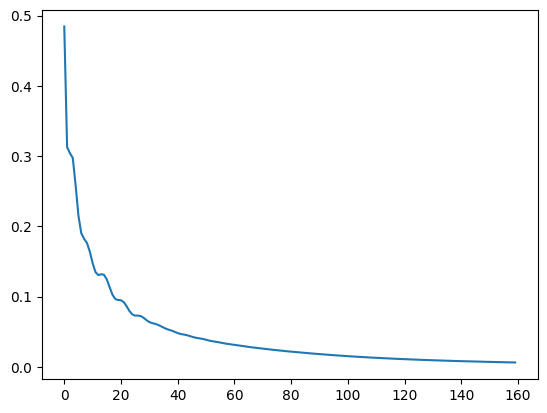

In [66]:
from sklearn.neural_network import MLPRegressor
model=MLPRegressor(hidden_layer_sizes=(100,),activation="relu",solver='adam', alpha=0.0001, batch_size='auto', learning_rate='constant', learning_rate_init=0.001, max_iter=500)
model.fit(X_train,Y_train[:,0])
y_pred=model.predict(X_test)
print("explained variance : ",explained_variance_score(y_pred,Y_test[:,0]))
plt.plot(model.loss_curve_)

In [7]:
X=pd.read_excel("./LSVT_voice_rehabilitation.xlsx",sheet_name="Data").dropna()
Y=pd.read_excel("./LSVT_voice_rehabilitation.xlsx",sheet_name="Binary response").dropna()
X=X.to_numpy()
Y=Y.to_numpy()
scaler=MinMaxScaler()
scaler.fit(X)
X_transformed=scaler.transform(X)
X_train,X_test,Y_train,Y_test=train_test_split(X,Y,test_size=0.5,random_state=49)
print(X_train.shape,X_test.shape,Y_train.shape,Y_test.shape)

(63, 310) (63, 310) (63, 1) (63, 1)


In [82]:
#plotter from murphy https://colab.research.google.com/github/probml/pyprobml/blob/master/notebooks/book1/09/discrim_analysis_dboundaries_plot2.ipynb
figdir = "figures"
def plotter(X_train, Y_train, u, sigma, clf, mstring):
  ngrid = 200
  # n_samples = 30

  def savefig(fname):
      plt.savefig(os.path.join(figdir, fname))

  def mvn2d(x, y, u, sigma):
      xx, yy = np.meshgrid(x, y)
      xy = np.c_[xx.ravel(), yy.ravel()]
      sigma_inv = np.linalg.inv(sigma)
      z = np.dot((xy - u), sigma_inv)
      z = np.sum(z * (xy - u), axis=1)
      z = np.exp(-0.5 * z)
      z = z / (2 * np.pi * np.linalg.det(sigma) ** 0.5)
      return z.reshape(xx.shape)

  def make_grid(x):
    points = np.vstack(x)
    x_min, y_min = np.min(points, axis=0)
    x_max, y_max = np.max(points, axis=0)
    x_range = np.linspace(x_min - 1, x_max + 1, ngrid)
    y_range = np.linspace(y_min - 1, y_max + 1, ngrid)
    xx, yy = np.meshgrid(x_range, y_range)
    return xx, yy, x_range, y_range

  def plot_points(x):
    c = "bgr"
    m = "xos"
    for i, point in enumerate(x):
        plt.plot(point[:, 0], point[:, 1], c[i] + m[i])
  
  def plot_contours(xx, yy, x_range, y_range, u, sigma):
    nclasses = len(u)
    c = "bgr"
    m = "xos"
    for i in range(nclasses):
        prob = mvn2d(x_range, y_range, u[i], sigma[i])
        cs = plt.contour(xx, yy, prob, colors=c[i])

  def plot_dboundaries(xx, yy, z, z_p):
    plt.pcolormesh(xx, yy, z, alpha=0.1)
    plt.jet()
    nclasses = z_p.shape[1]
    for j in range(nclasses):
        plt.contour(xx, yy, z_p[:, j].reshape(ngrid, ngrid), [0.5], colors="k")
  
  def make_one_hot(yhat):
    yy = yhat.reshape(-1, 1)  # make 2d
    enc = OneHotEncoder(sparse=False)
    Y = enc.fit_transform(yy)
    return Y
  
        
  classes = [0,1,2]
  x = []; labels = []
  for c in classes:
    class_indices = (Y_train == c)
    x.append(X_train[class_indices])
    labels.append(Y_train[class_indices])
  xx, yy, x_range, y_range = make_grid(x)
  X = np.vstack(x)
  Y = np.hstack(labels)

  # clf.fit(X, Y)
  z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
  z = z.reshape(ngrid, ngrid)
  z_p = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])
  yhat = clf.predict(np.c_[xx.ravel(), yy.ravel()])
  Yhat = make_one_hot(yhat)

  plt.figure()
  # plot_dboundaries(xx, yy, z, z_p)
  plot_dboundaries(xx, yy, z, Yhat)
  plot_points(x)
  if u is not None:
    plot_contours(xx, yy, x_range, y_range, u, sigma)
  plt.title(mstring)
  plt.axis("square")
  plt.tight_layout()
  savefig("gda_2d_{}.pdf".format(mstring))
  plt.show()
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis,LinearDiscriminantAnalysis
from sklearn.inspection import DecisionBoundaryDisplay
model=QuadraticDiscriminantAnalysis(store_covariance=True)
model.fit(X_train,Y_train.ravel())
y_pred=model.predict(X_test)
print("Accuracy: ",accuracy_score(y_pred,Y_test.ravel()))
# plotter(X_train[:30],Y_train[:30], model.means_, model.covariance_ ,model, "QDA")
model=LinearDiscriminantAnalysis(store_covariance=True)
model.fit(X_train,Y_train.ravel())
y_pred=model.predict(X_test)
print("Accuracy: ",accuracy_score(y_pred,Y_test.ravel()))
# plotter(X_train[:30],Y_train[:30], model.means_, model.covariance_ ,model, "LDA")


Accuracy:  0.7619047619047619
Accuracy:  0.7777777777777778


C:\Users\ATHIRA\AppData\Roaming\Python\Python310\site-packages\sklearn\discriminant_analysis.py:887: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


In [83]:
from sklearn.naive_bayes import GaussianNB as GNB
model=GNB()
model.fit(X_train,Y_train.ravel())
y_pred=model.predict(X_test)
print("Accuracy: ",accuracy_score(y_pred,Y_test.ravel()))


Accuracy:  0.3492063492063492


In [86]:
from sklearn.linear_model import LogisticRegression
model=LogisticRegression(penalty="none",max_iter=500)
model.fit(X_train,Y_train.ravel())
y_pred=model.predict(X_test)
print("Accuracy: ",accuracy_score(y_pred,Y_test.ravel()))

Accuracy:  0.7301587301587301


In [99]:
from sklearn.linear_model import LogisticRegression
model=LogisticRegression(penalty="l2",max_iter=500,multi_class="multinomial")
model.fit(X_train,Y_train.ravel())
y_pred=model.predict(X_test)
print("Accuracy: ",accuracy_score(y_pred,Y_test.ravel()))

Accuracy:  0.6825396825396826


0.7301587301587301


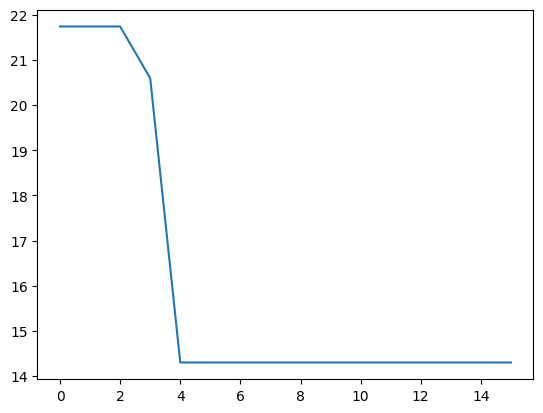

In [95]:
from sklearn.neural_network import MLPClassifier
model=MLPClassifier()
model.fit(X_train,Y_train[:,0])
# y_pred=model.predict(X_test)
print(model.score(X_test,Y_test.ravel()))
# print("Accuracy: ",accuracy_score(y_pred,Y_test.ravel()))
plt.plot(model.loss_curve_)

In [102]:
from sklearn.neighbors import KNeighborsClassifier
model= KNeighborsClassifier(2, weights="distance")
model.fit(X_train,Y_train[:,0])
print(model.score(X_test,Y_test.ravel()))
model= KNeighborsClassifier(2, weights="uniform")
model.fit(X_train,Y_train[:,0])
print(model.score(X_test,Y_test.ravel()))
model= KNeighborsClassifier(4, weights="uniform")
model.fit(X_train,Y_train[:,0])
print(model.score(X_test,Y_test.ravel()))
model= KNeighborsClassifier(3, weights="uniform")
model.fit(X_train,Y_train[:,0])
print(model.score(X_test,Y_test.ravel()))

0.5079365079365079
0.5396825396825397
0.5873015873015873
0.6190476190476191


In [8]:
from sklearn.svm import LinearSVC as SVC
model= SVC(C=1)
model.fit(X_train,Y_train[:,0])
print(model.score(X_test,Y_test.ravel()))

0.746031746031746


C:\Users\ATHIRA\AppData\Roaming\Python\Python310\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


array([-1.52955942, -1.51462041, -1.60244657])

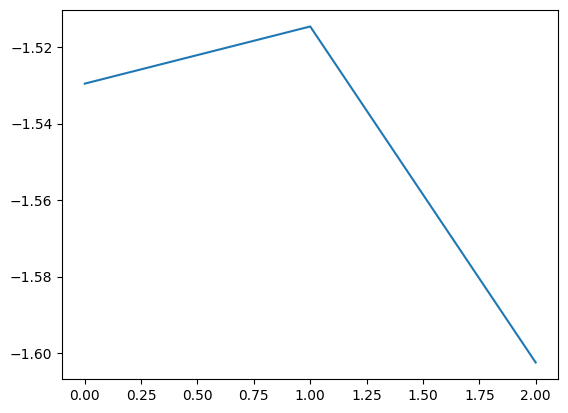

In [105]:
from sklearn.neighbors import KernelDensity
import numpy as np
rng = np.random.RandomState(42)
X = rng.random_sample((100, 3))
kde = KernelDensity(kernel='gaussian', bandwidth=0.5).fit(X)
log_density = kde.score_samples(X[:3])
plt.plot(log_density)
log_density

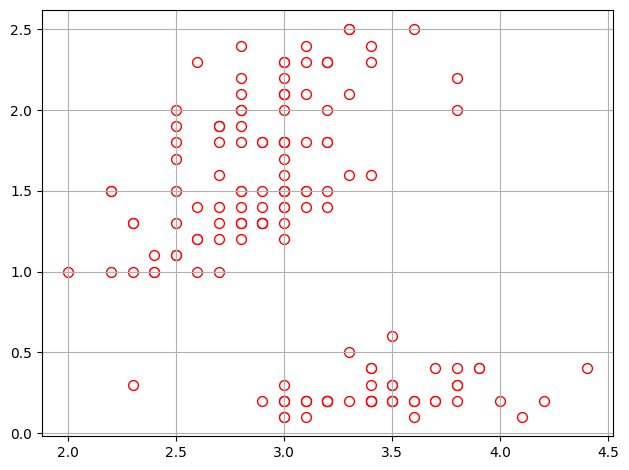

In [4]:
from sklearn import datasets
from sklearn.cluster import KMeans
#
# Load Sklearn IRIS dataset
#
iris = datasets.load_iris()
X = iris.data
y = iris.target
#
# Do the scatter plot and see that clusters are evident
#
plt.scatter(X[:,1], X[:,3],
             color='white', marker='o', edgecolor='red', s=50)
plt.grid()
plt.tight_layout()
plt.show()

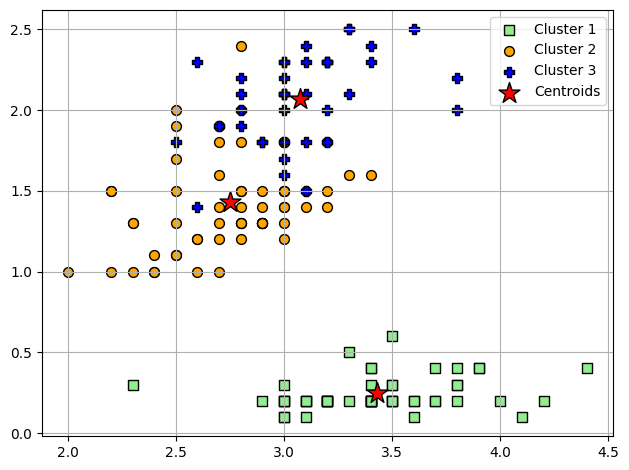

In [5]:
kmc = KMeans(n_clusters=3, init='random', n_init=10, max_iter=300,tol=1e-04, random_state=0)
#
# Fit and make predictions
#
y_kmc = kmc.fit_predict(X)
#
# Create the K-means cluster plot
#
plt.scatter(X[y_kmc == 0, 1], X[y_kmc == 0, 3], s=50,
            c='lightgreen', marker='s', edgecolor='black', label='Cluster 1')
plt.scatter(X[y_kmc == 1, 1], X[y_kmc == 1, 3],
             s=50, c='orange', marker='o', edgecolor='black', label='Cluster 2')
plt.scatter(X[y_kmc == 2, 1], X[y_kmc == 2, 3], s=50,
            c='blue', marker='P', edgecolor='black', label='Cluster 3')
plt.scatter(kmc.cluster_centers_[:, 1], kmc.cluster_centers_[:, 3],
            s=250, marker='*', c='red', edgecolor='black', label='Centroids')
plt.legend(scatterpoints=1)
plt.grid()
plt.tight_layout()
plt.show()


In [12]:
import numpy as np
from sklearn.mixture import GMM
# from sklearn.mixture import GaussianMixture as GMM
np.random.seed(1)
g = GMM(n_components=2)
# Generate random observations with two modes centered on 0
# and 10 to use for training.
obs = np.concatenate((np.random.randn(100, 1),
                      10 + np.random.randn(300, 1)))
g.fit(obs) 



np.round(g.weights_, 2)

np.round(g.means_, 2)


np.round(g.covars_, 2) 


g.predict([[0], [2], [9], [10]]) 

np.round(g.score([[0], [2], [9], [10]]), 2)

# Refit the model on new data (initial parameters remain the
# same), this time with an even split between the two modes.
g.fit(20 * [[0]] +  20 * [[10]]) 



np.round(g.weights_, 2)


ImportError: cannot import name 'GMM' from 'sklearn.mixture' (C:\Users\ATHIRA\AppData\Roaming\Python\Python310\site-packages\sklearn\mixture\__init__.py)

In [14]:
import numpy as np
from sklearn.decomposition import PCA
X = np.array([[-1, -1], [-2, -1], [-3, -2], [1, 1], [2, 1], [3, 2]])
pca = PCA()
pca.fit(X)

print(pca.explained_variance_ratio_)

print(pca.singular_values_)

[0.99244289 0.00755711]
[6.30061232 0.54980396]


In [1]:
from sklearn.datasets import make_regression
# define dataset
X, y = make_regression(n_samples=1000, n_features=100, n_informative=10, noise=0.1, random_state=1)
# summarize the dataset
print(X.shape, y.shape)

(1000, 100) (1000,)


In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=1)
# scale data
t = MinMaxScaler()
t.fit(X_train)
X_train = t.transform(X_train)
X_test = t.transform(X_test)

In [10]:
import torch
import torchvision
from torchvision.datasets import MNIST
import torchvision.transforms as transform
transformer=transform.Compose([transform.ToTensor(),transform.Normalize(0.25,0.55)])
trainset=MNIST(root="./data/",train=True,download=False,transform=transformer)
testset=MNIST(root="./data/",train=False,download=False,transform=transformer)


In [45]:
from torch.utils.data import DataLoader
trainloader=DataLoader(trainset,batch_size=4,num_workers=4,shuffle=True)
testloader=DataLoader(testset,batch_size=1,num_workers=4,shuffle=False)
class Mymodel(torch.nn.Module):
    def __init__(self):
        super(Mymodel, self).__init__()
        self.relu=torch.nn.ReLU()
        self.fc1=torch.nn.Linear(784,64)
        self.fc2=torch.nn.Linear(64,10)
        # self.softmax=torch.nn.Softmax()
    def forward(self,img):
        x=torch.flatten(img,1)
        # print(x.shape)
        
        x=self.fc1(x)
        x=self.relu(x)
        x=self.fc2(x)
        # x=self.softmax(x)
        return x
model=Mymodel()
device="cuda" if torch.cuda.is_available() else "cpu"
model=model.to(device)
print(model)
criterion=torch.nn.CrossEntropyLoss()
optimizer=torch.optim.SGD(params=model.parameters(),lr=0.01)

Mymodel(
  (relu): ReLU()
  (fc1): Linear(in_features=784, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=10, bias=True)
)


In [33]:
pytorch_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
pytorch_total_params

201418

In [46]:
def train(model):
    running_loss=0
    model.train()
    for i,(img,label) in enumerate(trainloader):
        img=img.to(device)
        label=label.to(device)
        pred=model(img)
        # print(pred.shape,label.shape,img.shape)
        loss=criterion(pred,label)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss+=loss.item()
    
    return model,running_loss
def validation(model):
    model.eval()
    running_loss=0
    accuracy=0
    for i,(img,label) in enumerate(testloader):
        img=img.to(device)
        label=label.to(device)
        pred=model(img)
        loss=criterion(pred,label)
        correct=(torch.argmax(pred)==label).sum()
        accuracy+=correct
        running_loss+=loss.item()
    return model,running_loss,accuracy
train_loss=[]
epochs=20
for i in range(epochs):
    model,running_loss=train(model)
    train_loss.append(running_loss/len(trainset))
    print("Train epoch : ",i,"loss : ",running_loss/len(trainset))
model,loss,accuracy=validation(model)
print(loss/len(testset),accuracy/len(testset))
torch.save(model.state_dict,"classifier.pth")
      
    
        

Train epoch :  15000 loss :  0.03127731382846832
Train epoch :  15000 loss :  0.0196305550634861
Train epoch :  15000 loss :  0.009212969802320004
